In [1]:
import pandas as pd
import numpy as np
import random
import os
import re
import subprocess
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from xgboost import XGBClassifier


In [2]:
data = pd.read_excel('/Users/rachael/Downloads/train_df_labelled copy.xlsx')
#the data verified by the third person will be used as the train set finally
file =  data[['content','sentiment']]
file['sentiment'].value_counts()
label_sentiment= file['sentiment'].value_counts()
label_proportions_sentiment= file['sentiment'].value_counts(normalize=True)
print("Counts of each label_sentiment:")
print(label_sentiment)
print("\nProportions of each label_sentiment:")
print(label_proportions_sentiment)

Counts of each label_sentiment:
sentiment
Negative    262
Neither      99
Positive     48
Name: count, dtype: int64

Proportions of each label_sentiment:
sentiment
Negative    0.640587
Neither     0.242054
Positive    0.117359
Name: proportion, dtype: float64


In [3]:
def remove_urls(text):
    # 定义URL的正则表达式
    url_pattern = r'https?://\S+|www\.\S+'
    # 使用re.sub()函数替换URL为空字符串
    no_url_text = re.sub(url_pattern, '', text)
    return no_url_text

def clean_text(text):
    # Remove anything that is not a letter or space
    clean_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Optional: Convert text to lower case
    clean_text = clean_text.lower()
    return clean_text

In [4]:
file['content'] = file['content'].apply(remove_urls) 
file['content'] = file['content'].apply(clean_text) 
file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
file.head()
y = file['sentiment']
X = file['content']

/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_86963/849503471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(remove_urls)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_86963/849503471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(clean_text)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_86963/849503471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [5]:
nlp = spacy.load("nl_core_news_sm")
#tokenize
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]

#load word2vec embeddings
model_path = '/Users/rachael/Downloads/39/model.bin'
word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)
vector_size = word_vectors.vector_size #100
#convert sentences feature to the average of word vectors
def sentence_to_avg_vec(tokens, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for token in tokens:
        if token in model:
            vec += model[token]
            count += 1
    if count != 0:
        vec /= count
    return vec

In [9]:
#define parameter range 
param_dist = {
    'learning_rate': [item/100 for item in range(1, 31)],
    'max_depth': [item for item in range(3, 11)],
    'subsample': [item/10 for item in range(5, 11)],
    'colsample_bytree': [item/10 for item in range(5, 11)],
    'lambda': [item/10 for item in range(0, 11)],
    'alpha': [item/10 for item in range(0, 11)],
}

best_score = 0
best_params = {}
test_scores = []
best_params_list = []
f1_scores = []

In [10]:
# Stratified K-fold for maintaining label distribution,shuffle=True确保每次迭代的数据划分不同
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# Loop over each fold
for train_index, test_index in outer_cv.split(X, y):
    trainX, testX = X.iloc[train_index], X.iloc[test_index]
    trainy, testy = y.iloc[train_index], y.iloc[test_index]

    # convert y_train and y_test to DataFrame
    y_train_df = pd.DataFrame(trainy).reset_index(drop=True)
    y_test_df = pd.DataFrame(testy).reset_index(drop=True)

    # concat X_train and y_train, X_test and y_test
    train_df = pd.concat([trainX.reset_index(drop=True), y_train_df], axis=1)
    test_df = pd.concat([testX.reset_index(drop=True), y_test_df], axis=1)
    
    #process data to the format that is acceptable by data augmentation technique
    train_df['content'] = train_df['content'].apply(lambda x: ' '.join(x.split()))
    sentiment_0 = train_df[train_df['sentiment'] == 0]
    sentiment_1 = train_df[train_df['sentiment'] == 1]
    sentiment_2 = train_df[train_df['sentiment'] == 2]
    
    #expand class0,save file as temporary files
    output_file_path0 = '/Users/rachael/Desktop/data/sentiment_0.txt'
    # convert DataFrame data into a simple tab-separated text file format，required by the data augmentation technique
    with open(output_file_path0, 'w', encoding='utf-8') as f:
        for _, row in sentiment_0.iterrows():
            f.write(f"{row['sentiment']}\t{row['content']}\n")   
    subprocess.run([
    'python', '/Users/rachael/Desktop/data/augment.py',
    '--input', output_file_path0,
    '--output', '/Users/rachael/Desktop/data/augmented_train0.txt',  # Output as txt if required
    '--num_aug', '9',
    '--alpha_sr', '0.1',
    '--alpha_rd', '0.1',
    '--alpha_ri', '0.1',
    '--alpha_rs', '0.1'
])

    #expand class1, save file as temporary files
    output_file_path1 = '/Users/rachael/Desktop/data/sentiment_1.txt'
    with open(output_file_path1, 'w', encoding='utf-8') as f:
        for _, row in sentiment_1.iterrows():
            f.write(f"{row['sentiment']}\t{row['content']}\n")  
    subprocess.run([
    'python', '/Users/rachael/Desktop/data/augment.py',
    '--input', output_file_path1,
    '--output', '/Users/rachael/Desktop/data/augmented_train1.txt',  # Output as txt if required
    '--num_aug', '1',
    '--alpha_sr', '0.1',
    '--alpha_rd', '0.1',
    '--alpha_ri', '0.1',
    '--alpha_rs', '0.1'
])
    
    #expand class2 
    output_file_path2 = '/Users/rachael/Desktop/data/sentiment_2.txt'
    with open(output_file_path2, 'w', encoding='utf-8') as f:
        for _, row in sentiment_2.iterrows():
            f.write(f"{row['sentiment']}\t{row['content']}\n")
    subprocess.run([
    'python', '/Users/rachael/Desktop/data/augment.py',
    '--input', output_file_path2,
    '--output', '/Users/rachael/Desktop/data/augmented_train2.txt',  # Output as txt if required
    '--num_aug', '4',
    '--alpha_sr', '0.1',
    '--alpha_rd', '0.1',
    '--alpha_ri', '0.1',
    '--alpha_rs', '0.1'
])
    
    # Load augmented data
    file4 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train0.txt', delimiter='\t', header=None, names=['sentiment', 'content'])
    file5 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train1.txt', delimiter='\t', header=None, names=['sentiment', 'content'])
    file6 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train2.txt', delimiter='\t', header=None, names=['sentiment', 'content'])
    augmented_train = pd.concat([file4,file5,file6])
   
    #process train_data
    augmented_train['content'] = augmented_train['content'].astype(str)
    y_train = augmented_train['sentiment']
    X_train = augmented_train['content']
    X_train_tokenized = X_train.apply(tokenize)

    #process test_data
    test_df['content'] = test_df['content'].astype(str)
    y_test = test_df['sentiment']
    X_test = test_df['content']
    X_test_tokenized = X_test.apply(tokenize)


    #map word embedding to tokenized train and test data
    X_train_embeddings = np.array([sentence_to_avg_vec(tokens, word_vectors, vector_size) for tokens in X_train_tokenized])
    X_test_embeddings= np.array([sentence_to_avg_vec(tokens, word_vectors, vector_size) for tokens in X_test_tokenized])
    
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    randomized_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings that are sampled
        scoring='f1_macro',
        n_jobs=-1,  # Use all available cores
        cv=inner_cv,
        random_state=42,
        verbose=1  # Set verbosity to get more information during the search
    )
    # Fit Randomized Search
    randomized_search.fit(X_train_embeddings, y_train)

    # Get the best model from Randomized Search
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_

    # Evaluate on the test set
    test_predictions = best_model.predict(X_test_embeddings)
    test_score = accuracy_score(y_test, test_predictions)
    test_f1_score = f1_score(y_test, test_predictions, average='macro')

    test_scores.append(test_score)
    f1_scores.append(test_f1_score)
    best_params_list.append(best_params)

    print(f"Fold test score: {test_score}")
    print(f"Fold F1-score: {test_f1_score}")
    print(f"Best parameters: {best_params}")

# Summarize the results
mean_test_score = np.mean(test_scores)
std_test_score = np.std(test_scores)
mean_f1_score = np.mean(f1_scores)
std_f1_score = np.std(f1_scores)

print(f"Mean test score: {mean_test_score}")
print(f"Standard deviation of test scores: {std_test_score}")
print(f"Mean F1-score: {mean_f1_score}")
print(f"Standard deviation of F1-scores: {std_f1_score}")
print("Best parameters for each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i + 1}: {params}")

generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_0.txt to /Users/rachael/Desktop/data/augmented_train0.txt with num_aug=9
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_1.txt to /Users/rachael/Desktop/data/augmented_train1.txt with num_aug=1
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_2.txt to /Users/rachael/Desktop/data/augmented_train2.txt with num_aug=4
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold test score: 0.6097560975609756
Fold F1-score: 0.4913663663663664
Best parameters: {'subsample': 0.5, 'max_depth': 6, 'learning_rate': 0.3, 'lambda': 0.7, 'colsample_bytree': 0.5, 'alpha': 0.1}
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_0.txt to /Users/rachael/Desktop/data/augmented_train0.txt with num_aug=9
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_1.txt to /Users/rachael/Desktop/data/augme

In [11]:
from collections import Counter
best_params_counter = Counter(tuple(sorted(params.items())) for params in best_params_list)
most_common_params = dict(best_params_counter.most_common(1)[0][0])

print("Most common best parameters:", most_common_params)

Most common best parameters: {'alpha': 0.1, 'colsample_bytree': 0.5, 'lambda': 0.7, 'learning_rate': 0.3, 'max_depth': 6, 'subsample': 0.5}


In [6]:
most_common_params = {'subsample': 0.5, 'max_depth': 6, 'learning_rate': 0.3, 'lambda': 0.7, 'colsample_bytree': 0.5, 'alpha': 0.1}


In [7]:
X_sentences = [item for item in list(X)]
X_tokenized = X.apply(tokenize)
X_embeddings = np.array([sentence_to_avg_vec(tokens, word_vectors, 100) for tokens in X_tokenized])

final_model = XGBClassifier(use_label_encoder=False, random_state=42,**most_common_params)
final_model.fit(X_embeddings, y)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.7, learning_rate=0.3,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [16]:
print(best_model)

XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.6,
              learning_rate=0.11, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)


In [8]:
test = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
test = test[['content','sentiment']]
test['content'] = test['content'].apply(remove_urls) 
test['content'] = test['content'].apply(clean_text) 
test['sentiment'] = test['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
test_tokenized = test['content'].apply(tokenize)
test_embedding = np.array([sentence_to_avg_vec(tokens,word_vectors,100) for tokens in test_tokenized])
test_predictions = final_model.predict(test_embedding)
test_score = accuracy_score(test['sentiment'], test_predictions)
conf_matrix = confusion_matrix(test['sentiment'], test_predictions)
class_report = classification_report(test['sentiment'], test_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.62      0.87      0.73       245
           2       0.49      0.24      0.32       124

    accuracy                           0.60       407
   macro avg       0.37      0.37      0.35       407
weighted avg       0.52      0.60      0.54       407



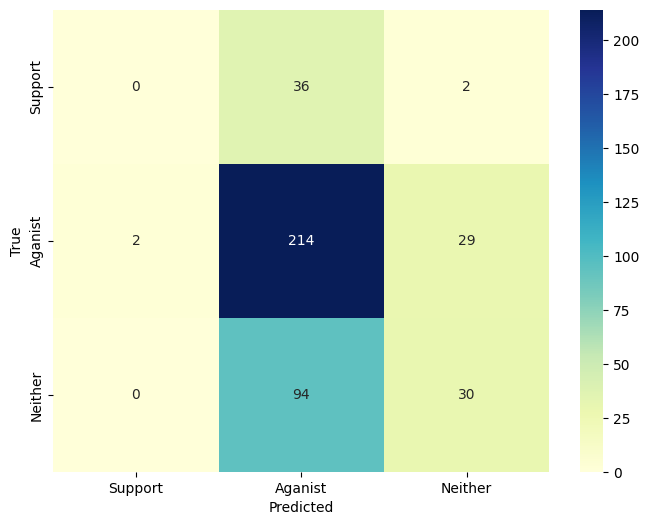

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# 绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Support', 'Aganist', 'Neither'], yticklabels=['Support', 'Aganist', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
data = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
file =  data[['content','stance','sentiment']]
file['stance'] = file['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
file['content'] = file['content'].apply(remove_urls) 
file['content'] = file['content'].apply(clean_text) 
stance_0_sentiment = file[file['stance'] == 0][['content','sentiment']]
stance_1_sentiment = file[file['stance'] == 1][['content','sentiment']]
stance_2_sentiment = file[file['stance'] == 2][['content','sentiment']] 


/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_2216/2304660705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['stance'] = file['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_2216/2304660705.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_2216/2304660705.py:6: Setti

In [30]:
stance_0_tokenized = stance_0_sentiment['content'].apply(tokenize)
stance_0_embedding = np.array([sentence_to_avg_vec(tokens,word_vectors,100) for tokens in stance_0_tokenized])
stance_0_predictions = best_model.predict(stance_0_embedding )
stance_0_class_report = classification_report(stance_0_sentiment['sentiment'], stance_0_predictions)
print('stance_0_class_report:',stance_0_class_report)

stance_0_class_report:               precision    recall  f1-score   support

           0       0.20      0.04      0.07        25
           1       0.52      0.89      0.66        38
           2       0.67      0.31      0.42        13

    accuracy                           0.51        76
   macro avg       0.46      0.41      0.38        76
weighted avg       0.44      0.51      0.42        76



In [32]:
stance_1_tokenized = stance_1_sentiment['content'].apply(tokenize)
stance_1_embedding = np.array([sentence_to_avg_vec(tokens,word_vectors,100) for tokens in stance_1_tokenized])
stance_1_predictions = best_model.predict(stance_1_embedding )
stance_1_class_report = classification_report(stance_1_sentiment['sentiment'], stance_1_predictions)
print('stance_1_class_report:',stance_1_class_report)

stance_1_class_report:               precision    recall  f1-score   support

           0       0.15      0.40      0.22         5
           1       0.93      0.76      0.83       170
           2       0.13      0.31      0.18        16

    accuracy                           0.71       191
   macro avg       0.40      0.49      0.41       191
weighted avg       0.84      0.71      0.76       191



In [33]:
stance_2_tokenized = stance_2_sentiment['content'].apply(tokenize)
stance_2_embedding = np.array([sentence_to_avg_vec(tokens,word_vectors,100) for tokens in stance_2_tokenized])
stance_2_predictions = best_model.predict(stance_2_embedding )
stance_2_class_report = classification_report(stance_2_sentiment['sentiment'], stance_2_predictions)
print('stance_2_class_report:',stance_2_class_report)

stance_2_class_report:               precision    recall  f1-score   support

           0       0.20      0.12      0.15         8
           1       0.28      0.62      0.38        37
           2       0.75      0.41      0.53        95

    accuracy                           0.45       140
   macro avg       0.41      0.39      0.36       140
weighted avg       0.59      0.45      0.47       140

